In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
from pmdarima import auto_arima


In [66]:
sales_data = pd.read_csv(r"C:\Users\surej\OneDrive\Desktop\project\ingredients_pred_capstone\Pizza_Sale - pizza_sales.csv")
ingredients_data = pd.read_csv(r"C:\Users\surej\OneDrive\Desktop\project\ingredients_pred_capstone\Pizza_ingredients - Pizza_ingredients.csv")

print(sales_data)
print("--------------------------------------------------------------------------------------------------------------------")
print(ingredients_data)


       pizza_id  order_id  pizza_name_id  quantity  order_date order_time  \
0             1         1     hawaiian_m         1    1/1/2015   11:38:36   
1             2         2  classic_dlx_m         1    1/1/2015   11:57:40   
2             3         2  five_cheese_l         1    1/1/2015   11:57:40   
3             4         2    ital_supr_l         1    1/1/2015   11:57:40   
4             5         2     mexicana_m         1    1/1/2015   11:57:40   
...         ...       ...            ...       ...         ...        ...   
48615     48616     21348  ckn_alfredo_m         1  31-12-2015   21:23:10   
48616     48617     21348  four_cheese_l         1  31-12-2015   21:23:10   
48617     48618     21348   napolitana_s         1  31-12-2015   21:23:10   
48618     48619     21349     mexicana_l         1  31-12-2015   22:09:54   
48619     48620     21350      bbq_ckn_s         1  31-12-2015   23:02:05   

       unit_price  total_price pizza_size pizza_category  \
0           13.

In [67]:
print(sales_data.isnull().sum())
print("------------------------------------------------------")
print(ingredients_data.isnull().sum())


pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64
------------------------------------------------------
pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64


In [68]:
mean_value = ingredients_data['Items_Qty_In_Grams'].mean()
ingredients_data['Items_Qty_In_Grams'].fillna(mean_value, inplace=True)

C:\Users\surej\AppData\Local\Temp\ipykernel_8464\2192417003.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ingredients_data['Items_Qty_In_Grams'].fillna(mean_value, inplace=True)


In [69]:
sales_data.dropna(inplace=True)

In [70]:
print(sales_data.isnull().sum())
print("------------------------------------------------------")
print(ingredients_data.isnull().sum())

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64
------------------------------------------------------
pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
dtype: int64


In [71]:
def clean_dates(date_str):
    # Example: replace hyphens with slashes
    if isinstance(date_str, str):
        return date_str.replace('-', '/')
    return date_str

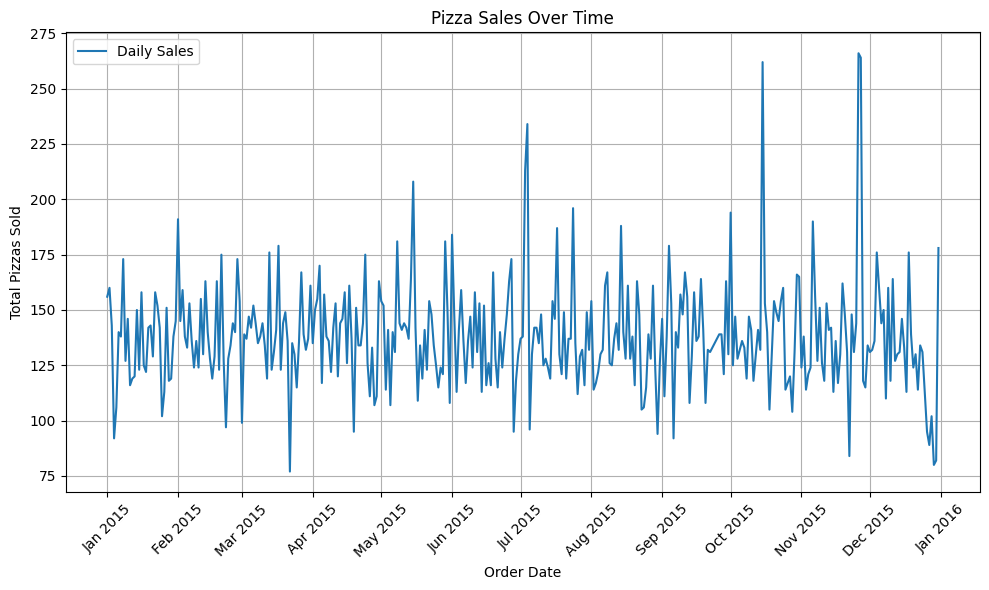

In [72]:
sales_data['order_date'] = sales_data['order_date'].apply(clean_dates)

# Convert order_date to datetime, allowing mixed formats and day-first interpretation
sales_data['order_date'] = pd.to_datetime(sales_data['order_date'], dayfirst=True, errors='coerce')

# Group by date and sum the quantities
daily_sales = sales_data.groupby('order_date')['quantity'].sum().reset_index()

# Plot daily sales over time with improved formatting
plt.figure(figsize=(10,6))
plt.plot(daily_sales['order_date'], daily_sales['quantity'], label='Daily Sales')

# Set title and labels
plt.title('Pizza Sales Over Time')
plt.xlabel('Order Date')
plt.ylabel('Total Pizzas Sold')

# Improve the x-axis date format and reduce the number of ticks
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Set ticks every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format dates as 'Month Year'

plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()  # Adjust layout to ensure labels fit
plt.show()


In [73]:
daily_sales = sales_data.groupby('order_date')['quantity'].sum().reset_index()
daily_sales

,order_date,quantity
0,2015-01-01,156
1,2015-01-02,160
2,2015-01-03,143
3,2015-01-04,92
4,2015-01-05,106
...,...,...
353,2015-12-27,89
354,2015-12-28,102
355,2015-12-29,80
356,2015-12-30,82


In [74]:
print(sales_data.isnull().sum())
print("------------------------------------------------------")
print(ingredients_data.isnull().sum())

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64
------------------------------------------------------
pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
dtype: int64


In [75]:
# Extract useful time-based features
sales_data['day_of_week'] = sales_data['order_date'].dt.dayofweek
sales_data['month'] = sales_data['order_date'].dt.month
sales_data['week_start'] = sales_data['order_date'] - pd.to_timedelta(sales_data['order_date'].dt.weekday, unit='D')  # Get week start (Monday)
sales_data['week'] = sales_data['order_date'].dt.isocalendar().week
sales_data['year'] = sales_data['order_date'].dt.year

# Create a feature to flag holidays
def is_holiday(date):
    holidays = [
    "2015-01-01",  # New Year's Day
    "2015-01-14",  # Makar Sankranti / Pongal
    "2015-01-26",  # Republic Day
    "2015-02-17",  # Maha Shivaratri
    "2015-03-06",  # Holi
    "2015-03-28",  # Ram Navami
    "2015-04-02",  # Mahavir Jayanti
    "2015-04-03",  # Good Friday
    "2015-05-01",  # May Day
    "2015-07-18",  # Eid al-Fitr
    "2015-08-15",  # Independence Day
    "2015-08-29",  # Raksha Bandhan
    "2015-09-17",  # Ganesh Chaturthi
    "2015-09-25",  # Eid al-Adha
    "2015-10-02",  # Gandhi Jayanti
    "2015-10-22",  # Dussehra
    "2015-11-11",  # Diwali
    "2015-11-25",  # Guru Nanak Jayanti
    "2015-12-25",  # Christmas
]
    return 1 if date.strftime("%Y-%m-%d") in holidays else 0

sales_data['is_holiday'] = sales_data['order_date'].apply(is_holiday)


C:\Users\surej\AppData\Local\Temp\ipykernel_8464\1566376426.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_holiday', y='quantity', data=holiday_sales, palette='Set2')


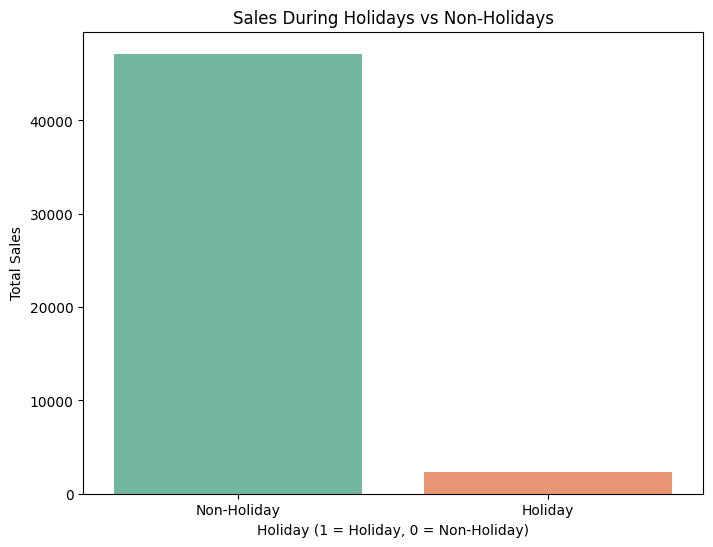

In [76]:
holiday_sales = sales_data.groupby('is_holiday')['quantity'].sum().reset_index()

# Plotting the comparison
plt.figure(figsize=(8, 6))
sns.barplot(x='is_holiday', y='quantity', data=holiday_sales, palette='Set2')

# Customizing the plot
plt.title('Sales During Holidays vs Non-Holidays')
plt.xlabel('Holiday (1 = Holiday, 0 = Non-Holiday)')
plt.ylabel('Total Sales')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.show()



In [77]:
# Counting the number of holidays and non-holidays
total_days = sales_data['order_date'].nunique()  # Get the number of unique dates
holidays_count = sales_data[sales_data['is_holiday'] == 1]['order_date'].nunique()  # Get the number of unique holidays
non_holidays_count = total_days - holidays_count  # Number of non-holidays

print(f"Total days: {total_days}")
print(f"Number of holidays: {holidays_count}")
print(f"Number of non-holidays: {non_holidays_count}")

# Grouping by 'is_holiday' and summing up 'total_sales' to compare holiday and non-holiday sales
holiday_sales = sales_data.groupby('is_holiday')['quantity'].sum().reset_index()

# Extracting the total sales for holidays and non-holidays
total_sales_holidays = holiday_sales[holiday_sales['is_holiday'] == 1]['quantity'].values[0]
total_sales_non_holidays = holiday_sales[holiday_sales['is_holiday'] == 0]['quantity'].values[0]

# Calculating percentage sales
total_sales = total_sales_holidays + total_sales_non_holidays
percentage_sales_holidays = (total_sales_holidays / total_sales) * 100
percentage_sales_non_holidays = (total_sales_non_holidays / total_sales) * 100

print(f"Total sales during holidays: {total_sales_holidays}")
print(f"Total sales during non-holidays: {total_sales_non_holidays}")
print(f"Percentage of sales during holidays: {percentage_sales_holidays:.2f}%")
print(f"Percentage of sales during non-holidays: {percentage_sales_non_holidays:.2f}%")


Total days: 358
Number of holidays: 17
Number of non-holidays: 341
Total sales during holidays: 2361
Total sales during non-holidays: 47147
Percentage of sales during holidays: 4.77%
Percentage of sales during non-holidays: 95.23%


In [78]:
holidays_count = sales_data[sales_data['is_holiday'] == 1]['order_date'].nunique()
non_holidays_count = sales_data[sales_data['is_holiday'] == 0]['order_date'].nunique()

holiday_sales_data = sales_data.groupby('is_holiday')['quantity'].sum().reset_index()

total_sales_holidays = holiday_sales_data[holiday_sales_data['is_holiday'] == 1]['quantity'].values[0]
total_sales_non_holidays = holiday_sales_data[holiday_sales_data['is_holiday'] == 0]['quantity'].values[0]

average_sales_holidays = total_sales_holidays / holidays_count
average_sales_non_holidays = total_sales_non_holidays / non_holidays_count

print(f"Average sales per day during holidays: {average_sales_holidays:.2f}")
print(f"Average sales per day during non-holidays: {average_sales_non_holidays:.2f}")

if average_sales_holidays > average_sales_non_holidays:
    print("Sales increase during holidays.")
elif average_sales_holidays < average_sales_non_holidays:
    print("Sales decrease during holidays.")
else:
    print("Sales are the same during holidays and non-holidays.")


Average sales per day during holidays: 138.88
Average sales per day during non-holidays: 138.26
Sales increase during holidays.


In [79]:
print(sales_data.isnull().sum())
print("------------------------------------------------------")
print(ingredients_data.isnull().sum())

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
day_of_week          0
month                0
week_start           0
week                 0
year                 0
is_holiday           0
dtype: int64
------------------------------------------------------
pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
dtype: int64


In [80]:
sales_data

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,day_of_week,month,week_start,week,year,is_holiday
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,3,1,2014-12-29,1,2015,1
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,3,1,2014-12-29,1,2015,1
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,3,1,2014-12-29,1,2015,1
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,3,1,2014-12-29,1,2015,1
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,3,1,2014-12-29,1,2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48615,48616,21348,ckn_alfredo_m,1,2015-12-31,21:23:10,16.75,16.75,M,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",The Chicken Alfredo Pizza,3,12,2015-12-28,53,2015,0
48616,48617,21348,four_cheese_l,1,2015-12-31,21:23:10,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza,3,12,2015-12-28,53,2015,0
48617,48618,21348,napolitana_s,1,2015-12-31,21:23:10,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza,3,12,2015-12-28,53,2015,0
48618,48619,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,3,12,2015-12-28,53,2015,0


In [83]:
sales_data['order_date'] = pd.to_datetime(sales_data['order_date'])

weekly_sales = sales_data.groupby([pd.Grouper(key='order_date', freq='W-MON'), 'pizza_name_id'])['quantity'].sum().reset_index()

future_predictions = []

for pizza_name_id in weekly_sales['pizza_name_id'].unique():
    pizza_sales = weekly_sales[weekly_sales['pizza_name_id'] == pizza_name_id]
    pizza_sales.set_index('order_date', inplace=True)

    print(f"Generating forecast for pizza_name_id: {pizza_name_id}")

    model = ARIMA(pizza_sales['quantity'], order=(4, 0, 0))  
    model_fit = model.fit()

    future_steps = 1

    future_forecast = model_fit.forecast(steps=future_steps)

    future_dates = pd.date_range(start=pizza_sales.index[-1] + pd.Timedelta(weeks=1), periods=future_steps, freq='W-MON')

    forecast_df = pd.DataFrame({
        'order_date': future_dates,
        'predicted_sales': future_forecast,
        'pizza_name_id': pizza_name_id
    })

    future_predictions.append(forecast_df)

all_forecasts = pd.concat(future_predictions).reset_index(drop=True)

print("\nPredicted sales for the next 1 weeks:\n")
print(all_forecasts[['predicted_sales','pizza_name_id']])

ingredient_requirements = pd.merge(all_forecasts, ingredients_data, on='pizza_name_id', how='left')

ingredient_requirements['total_ingredient_qty'] = ingredient_requirements['predicted_sales'] * ingredient_requirements['Items_Qty_In_Grams']

total_ingredient_needs = ingredient_requirements.groupby('pizza_ingredients')['total_ingredient_qty'].sum().reset_index()

print("\nIngredients required for the next 1 weeks of predicted sales:\n")
print(total_ingredient_needs)

total_ingredient_needs.to_csv(r'C:\Users\surej\OneDrive\Desktop\project\ingredients_pred_capstone\ingredients.csv')
all_forecasts.to_csv(r'C:\Users\surej\OneDrive\Desktop\project\ingredients_pred_capstone\prediction.csv')

Generating forecast for pizza_name_id: bbq_ckn_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: bbq_ckn_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: bbq_ckn_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: big_meat_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: brie_carre_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: calabrese_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: calabrese_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be g

Generating forecast for pizza_name_id: cali_ckn_l
Generating forecast for pizza_name_id: cali_ckn_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: cali_ckn_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: ckn_alfredo_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be g

Generating forecast for pizza_name_id: ckn_alfredo_m
Generating forecast for pizza_name_id: ckn_alfredo_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be g

Generating forecast for pizza_name_id: ckn_pesto_l
Generating forecast for pizza_name_id: ckn_pesto_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: ckn_pesto_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: classic_dlx_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: classic_dlx_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: classic_dlx_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: five_cheese_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: four_cheese_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: four_cheese_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: green_garden_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be g

Generating forecast for pizza_name_id: green_garden_m
Generating forecast for pizza_name_id: green_garden_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: hawaiian_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: hawaiian_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: hawaiian_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: ital_cpcllo_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: ital_cpcllo_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: ital_cpcllo_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: ital_supr_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: ital_supr_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: ital_supr_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be g

Generating forecast for pizza_name_id: ital_veggie_l
Generating forecast for pizza_name_id: ital_veggie_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: ital_veggie_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: mediterraneo_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: mediterraneo_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be g

Generating forecast for pizza_name_id: mediterraneo_s
Generating forecast for pizza_name_id: mexicana_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: mexicana_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: mexicana_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be g

Generating forecast for pizza_name_id: napolitana_l
Generating forecast for pizza_name_id: napolitana_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: napolitana_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: pep_msh_pep_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: pep_msh_pep_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: pep_msh_pep_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: pepperoni_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: pepperoni_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: pepperoni_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: peppr_salami_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: peppr_salami_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: peppr_salami_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: prsc_argla_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: prsc_argla_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: prsc_argla_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: sicilian_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: sicilian_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: sicilian_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: soppressata_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: soppressata_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: soppressata_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: southw_ckn_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: southw_ckn_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: southw_ckn_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: spicy_ital_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: spicy_ital_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: spicy_ital_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: spin_pesto_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be g

Generating forecast for pizza_name_id: spin_pesto_m
Generating forecast for pizza_name_id: spin_pesto_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: spinach_fet_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: spinach_fet_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: spinach_fet_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: spinach_supr_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: spinach_supr_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be g

Generating forecast for pizza_name_id: spinach_supr_s
Generating forecast for pizza_name_id: thai_ckn_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: thai_ckn_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: thai_ckn_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: the_greek_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: the_greek_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: the_greek_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: the_greek_xl


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: veggie_veg_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: veggie_veg_m


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: veggie_veg_s


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: calabrese_l


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Generating forecast for pizza_name_id: the_greek_xxl


c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Predicted sales for the next 1 weeks:

    predicted_sales  pizza_name_id
0         18.399925      bbq_ckn_l
1         17.218952      bbq_ckn_m
2          9.773546      bbq_ckn_s
3         37.340284     big_meat_s
4          8.509169   brie_carre_s
..              ...            ...
86         6.567697   veggie_veg_l
87         8.454898   veggie_veg_m
88         8.262843   veggie_veg_s
89         4.738075    calabrese_l
90         1.176935  the_greek_xxl

[91 rows x 2 columns]

Ingredients required for the next 1 weeks of predicted sales:

          pizza_ingredients  total_ingredient_qty
0              ?duja Salami            781.196536
1             Alfredo Sauce            331.753036
2                 Anchovies            792.583242
3                Artichokes           2394.165188
4                   Arugula            280.727508
..                      ...                   ...
59       Sun-dried Tomatoes            376.203084
60  Thai Sweet Chilli Sauce           1022.335619
61 

c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\surej\OneDrive\Desktop\project\.vene\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
